<a href="https://colab.research.google.com/github/gkteco/fastai-pytorch-walkthroughs/blob/main/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from fastai.collab import *
from fastai.tabular.all import *
import torch
import numpy as np


# probabilistic collaborative filtering is a very useful ML technique to find
# latent relationships between two items. Say we have a bunch of movies and a bunch
# of users and we want to find which users will like which movies. This problem
# can be framed as a collaborative filtering problem. The foundational idea here
# is that we will learn "latent factors" that is, have the model try to understand
# the relationships between all movies and users by learning a high demensional
# vector called an embedding.

path = untar_data(URLs.ML_100k)
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/ub.test'),Path('/root/.fastai/data/ml-100k/u5.base'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/u3.test'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/allbut.pl')...]

In [5]:
# assemble the data

ratings = pd.read_csv(path/"u.data", delimiter="\t", header=None,
                      names=["user", "movie", "rating", "timestamp"])

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
# Now that we have the user ID and the Movie ID and the respective rating that
# user has given that movie, let's contruct a synthetic example before training
# a model.


# Let's start by encoding a movie, say scarface....and scarface is
# *very* action, *kinda* romantic, and *very* not family freindly
scarface = np.array([0.98, 0.60, 0.1]) # this encodes our movie

# Now let's encode a user. Our user really likes action, will tolerate romance
# (as long as thier is action), and is indifferent to famil freindly movies.
user1 = np.array([0.9, 0.5, 0.3]) # this encodes our user

# and we have another user who hates action, loves romanc, and is also indifferent to
# family freindly movies.
user2 = np.array([0.1, 0.9, 0.2]) # this encodes our user

# Now, let's see if our user will like our movie
user1 @ scarface.T, user2 @ scarface.T, user1 @ user2.T

(1.212, 0.658, 0.6000000000000001)

In [14]:
# in our tuple above we can see that the value for the dot product of
# user1 and scarface is higher than the user2 and scarface.
# this makes sense as we predefined user1 as having traits that would
# like scarface more than user2 would.
# Furthermore, we can evaluate and asign a score to the users on how similar
# they are. This is the fundamental idea behind training a model to learn latent
# represntations with embeddigns.

# let's create a DataLoaders for movies and users

movies = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1",
                     usecols=(0,1), names=("movie", "title"), header=None)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [18]:
# Now let's merge movies and ratings. Pandas merge method allows us
# to do just that.
ratings = ratings.merge(movies)

In [19]:
# Now let's assemble our DataLoader

dls = CollabDataLoaders.from_df(ratings,
                                item_name="title",
                                bs=64)
dls.show_batch()

,user,title,rating
0,560,Blade Runner (1982),5
1,401,"Philadelphia Story, The (1940)",2
2,256,Bio-Dome (1996),1
3,280,Die Hard: With a Vengeance (1995),2
4,537,Boogie Nights (1997),4
5,706,Contact (1997),4
6,610,Apt Pupil (1998),4
7,586,Crimson Tide (1995),4
8,234,Cool Runnings (1993),3
9,843,Mary Poppins (1964),2


In [23]:
# before we get into training a model it's useful to work through
# what an embedding actually is. What we need to do, given our data is
# 1) take the user ID and look up into the user_factors and grab our "embedding"
# 2) take the movie ID and look up in the movie_factors and grab our "embedding"
# 3) perform the dotproduct to get a "similarity score"
n_users = len(dls.classes["user"])
n_movies = len(dls.classes["title"])
n_factors = 5
n_users, n_movies, n_factors

(944, 1665, 5)

In [24]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [36]:
# however, looking up in an index is not exactly something that our model
# can do. Our models know how to do matmuls. That beign said we need something
# that is equivalent to an index look up that we can express as a matmul.

# Say we wanted the user_factor for the user id 3
user_factors[3]

tensor([-0.3236,  0.0212, -1.7298,  0.3868, -0.1468])

In [38]:
# This works but again we want to expres this as a matmul
# we could do the same by doing a dot product with a one hot encoded
# vector where the position at 3 is flipped to one and the rest zero.
one_hot_3 = one_hot(3, n_users).float()
one_hot_3.shape

torch.Size([944])

In [40]:
# Now we simply matrix multiply

embedding = user_factors.t() @ one_hot_3
embedding

tensor([-0.3236,  0.0212, -1.7298,  0.3868, -0.1468])

In [56]:
# as you can see, we have the equivalent result.
# Now we have the basic concept of what an embedding is
# it's just a computational short cut to store numbers for an
# ID and do a lookup to access those numbers. This embedding is what will
# be learned by the model.

# Now let's define our model.

class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_dim):
    self.user_factors = Embedding(n_users, n_dim) # (n_users, n_dim)
    self.movie_factors = Embedding(n_movies, n_dim) # (n_movies, n_dim)

  def forward(self, x):
    user_embs = self.user_factors(x[:, 0]) # (x.shape[0], n_dim)
    movie_embs = self.movie_factors(x[:, 1]) # (x.shape[0], n_dim)
    # (x.shape[0], n_dim) * (x.shape[0], n_dim) --> (x.shape[0], )
    return (user_embs * movie_embs).sum(dim=1) #


In [57]:
# Let's test the model we just declared
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [62]:
model = DotProduct(n_users, n_movies, n_dim=5)
learn = Learner(dls, model,  loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,13.472599,13.139642,00:10
1,8.017935,7.696951,00:10
2,3.821172,3.852016,00:11
3,2.883151,2.963386,00:10
4,2.823548,2.858124,00:10


In [75]:
# Now let's look at the models output
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [76]:
# model activations for the first user movie pair in our batch
activs = model(x)[0]
activs

tensor(2.4279, grad_fn=<SelectBackward0>)

In [78]:
# Let's make sure we understand the models activation

# first grab the user ids from x
user_id = x[0][0] # this is the first user in our batch
movie_id = x[0][1] # this is the first movie in our batch
user_id.item(), movie_id.item()

(624, 1183)

In [81]:
# now that we have the IDs. let's grab their embeddings

user_embs = model.user_factors(user_id)
movie_embs = model.movie_factors(movie_id)
print(user_embs) # print embedding
print(movie_embs)

tensor([-0.7960,  0.7541, -0.7924, -0.7495, -0.7618],
       grad_fn=<EmbeddingBackward0>)
tensor([-0.6261,  0.6000, -0.6492, -0.6384, -0.6355],
       grad_fn=<EmbeddingBackward0>)


In [94]:
# now let's do the dot product and see if we have the same activation
(user_embs * movie_embs).sum()

# And doing the activation manualy we see that we have the same value that
# is coming out of the model. Now, let's try to improve the model. Let's
# look at the activations again.
model(x), y.squeeze(dim=1)

(tensor([2.4279, 1.4889, 3.5206, 3.5673, 3.6373, 3.2309, 2.4322, 2.6273, 3.4349,
         1.8016, 1.5340, 5.1556, 3.8402, 3.5416, 2.3618, 2.9980, 2.8831, 1.8577,
         1.9339, 3.3824, 4.5187, 1.5968, 1.5212, 1.5585, 3.1590, 0.9204, 2.5216,
         2.6174, 3.3235, 4.0993, 1.1611, 2.3471, 1.9164, 2.7124, 3.5376, 1.8733,
         1.6008, 3.1043, 4.1519, 3.3091, 3.6067, 0.2352, 3.6300, 2.6020, 2.9505,
         4.1674, 1.2842, 2.6679, 2.7363, 4.0284, 3.0059, 2.2452, 2.7925, 0.4252,
         4.1931, 4.5672, 2.2627, 1.5545, 1.4519, 2.1847, 1.7117, 4.5274, 1.2511,
         2.7613], grad_fn=<SumBackward1>),
 tensor([4, 4, 5, 3, 3, 4, 5, 5, 4, 5, 3, 5, 4, 5, 5, 4, 4, 3, 5, 5, 3, 1, 5, 1,
         4, 3, 3, 4, 5, 5, 5, 5, 1, 3, 2, 3, 3, 5, 3, 3, 5, 1, 4, 5, 4, 3, 3, 4,
         2, 5, 4, 4, 3, 3, 5, 5, 4, 3, 4, 3, 3, 4, 3, 2], dtype=torch.int8))

In [97]:
# We can see that some values are above that some values our over 5
# this does not make sense so let's scale all the value to be between
# 0 and 5.

class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_dim, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_dim)
    self.movie_factors = Embedding(n_movies, n_dim)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [98]:
# Now let's retrain the model
model = DotProduct(n_users, n_movies, 5)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,1.780257,1.810392,00:11
1,1.164605,1.216597,00:10
2,0.981005,1.045225,00:10
3,0.994688,1.014059,00:10
4,0.955569,1.010223,00:11


In [101]:
# Now we need to consider that some user's watch much more movies than others
# Some users will be more active in reviews than others and the model will
# be over catored to those users as they are the ones giving the most reviews.
# What if some users are generally more positive than others?
# What if some movies are just generally more liked than others?
# Right now we only have weights. To handle this peice of missing information
# we need to also have a biased term, that is, a number that we can add to
# all of the activations that will account for this information.

class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_dim, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_dim)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_dim)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0]) # (batch_size, n_dim)
    movies = self.movie_factors(x[:, 1]) # (batch_size, n_dim)
    res = (users * movies).sum(dim=1, keepdim=True) # (batch_size, )
    res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
    return sigmoid_range(res, *self.y_range)

In [102]:
# Now let's train again with our updated model
model = DotProduct(n_users, n_movies, 5)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,1.454060,1.456781,00:12
1,0.977568,0.993784,00:11
2,0.906348,0.933963,00:11
3,0.851857,0.920590,00:11
4,0.838047,0.918597,00:10


In [105]:
# we are getting a better system. Let's now try adding L2 regularizaiton
# also known as weight decay.
# What this does is it adds to your loss function a sum all of the weights
# squared. Why do we want to do this? Well this will force our weights to be
# small. This will make for a smoother function and keep the model from
# overfitting. The formula looks something like this:
# los_with_wd = loss + wd + (paremeters**2).sum()
# we can do this by passing in wd to our learner

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(10, 1e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.727462,1.700028,00:14
1,0.958690,0.999434,00:19
2,0.840235,0.912386,00:20
3,0.787411,0.878319,00:15
4,0.745559,0.860003,00:13
5,0.684488,0.849134,00:25
6,0.700548,0.841333,00:16
7,0.692744,0.837203,00:13
8,0.669636,0.835464,00:12
9,0.650398,0.835181,00:13


In [126]:
# Interpretting the model.

# One of the easiest things to interpret is the bias of the movies and the users
t = torch.arange(0, n_movies, 1)
movie_bias = learn.model.movie_bias(t).squeeze()
idxs = movie_bias.argsort()[:5]
print([dls.classes["title"][i] for i in idxs])

# Let's think about what this means. These are the lowest biases based on our
# model. Intuitivly this is the movies with the least bias for improving the
# rating of a user for these movies. This means that even when a user
# generally likes the geners appeard here in this list, they tend to not
# like these movies. Let's do the same thing but for the top 5 highest biased
# movies....
idxs = movie_bias.argsort()[-5:]
print([dls.classes["title"][i] for i in idxs])

# These movies mean the opposite. What this tells us that even when a user
# may not like the gener of the movies in this list, they still generally
# like these movies. We could do the same for users. User's with a high bias
# mean that they tend to like everything while users with low bias
# well....don't like much

['Children of the Corn: The Gathering (1996)', 'Crow: City of Angels, The (1996)', 'Amityville II: The Possession (1982)', 'Free Willy 3: The Rescue (1997)', 'Beautician and the Beast, The (1997)']
['L.A. Confidential (1997)', 'Silence of the Lambs, The (1991)', 'Shawshank Redemption, The (1994)', 'Good Will Hunting (1997)', 'Titanic (1997)']


In [129]:
# the next step to interpreting the model is visualizing the models parameters
# in a way that is relavent to the task. Something that is very interesting about
# these models is that during the task of predicting the score a user will give a movie
# the model learns latent representations of movies that naturally groups similar
# movies together. We can actually visulalize this by taking a shuffled sample of
# our dataset and projecting our high deminsional data to a 2d (of even 3d) graph.
# similar items will be points that are closer together and points that are further away from
# eachother are movies that are not very similar.
movie_embs_idx = torch.arange(0, n_movies, 1)
movie_embs = learn.model.movie_factors(movie_embs_idx)
movie_embs.shape

torch.Size([1665, 50])

In [146]:
np.random.seed(42)
shuffled_idxs = np.random.permutation(movie_embs.shape[0])[:300]
downsampled_movie_embs = movie_embs[shuffled_idxs]
downsampled_movie_embs.shape

torch.Size([300, 50])

In [147]:
labels = [dls.classes["title"][i] for i in shuffled_idxs]

In [148]:
# we will perform dimensionality reduction with TSNE and PCA so that we can
# visulalize our data.
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tnse = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2, random_state=42)
embeddings2d_tsne = tnse.fit_transform(downsampled_movie_embs.cpu().detach().numpy())
embeddings2d_pca = pca.fit_transform(downsampled_movie_embs.cpu().detach().numpy())
embeddings2d_tsne.shape, embeddings2d_pca.shape

((300, 2), (300, 2))

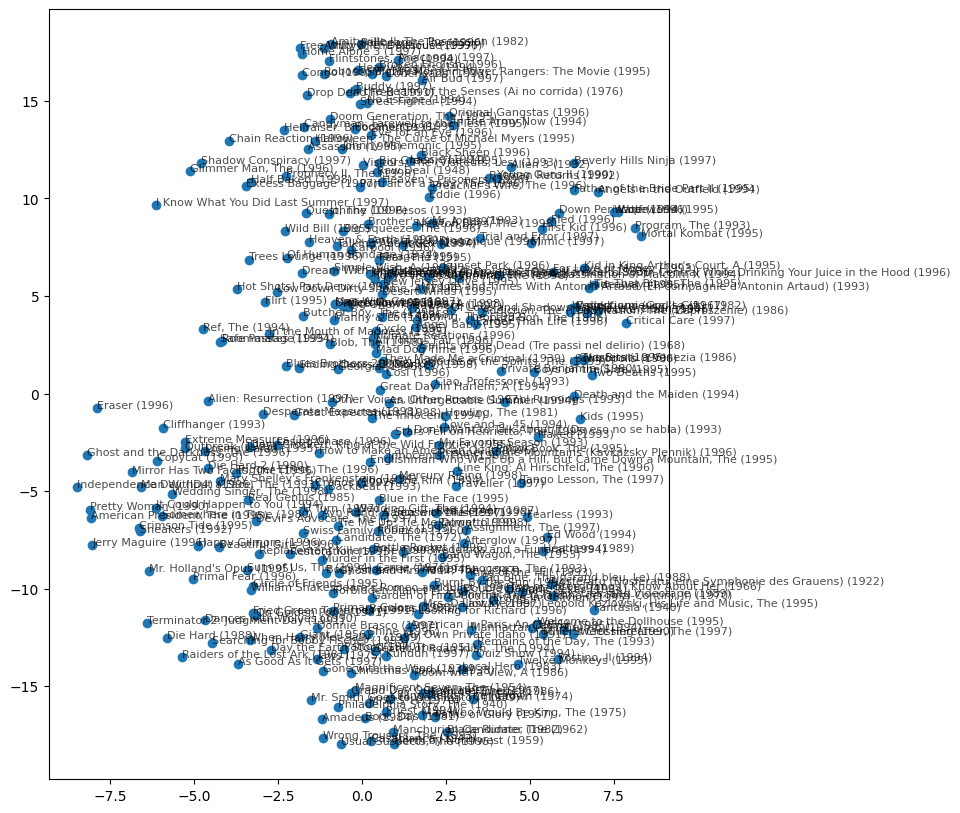

In [152]:
plt.figure(figsize=(8, 10))
plt.scatter(embeddings2d_tsne[:, 0], embeddings2d_tsne[:, 1])

for i, (x, y) in enumerate(embeddings2d_tsne):
  plt.annotate(labels[i], (x, y), fontsize=8, alpha=0.7)

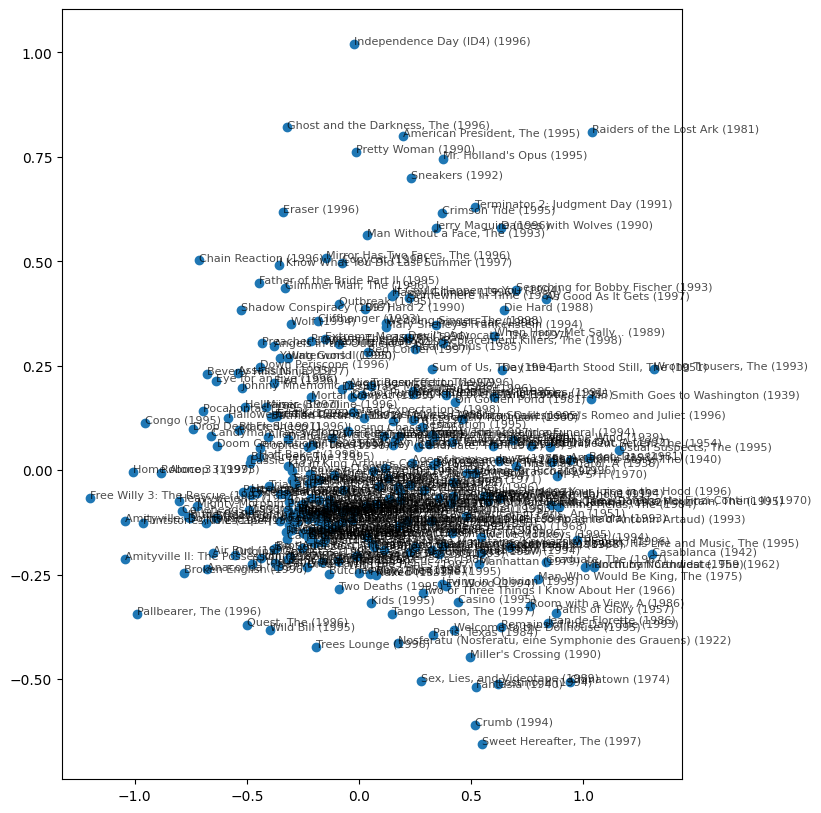

In [150]:
plt.figure(figsize=(8, 10))
plt.scatter(embeddings2d_pca[:, 0], embeddings2d_pca[:, 1])

for i, (x, y) in enumerate(embeddings2d_pca):
  plt.annotate(labels[i], (x, y), fontsize=8, alpha=0.7)